# Import necessary libraries

In [1]:
%matplotlib notebook
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.widgets import RectangleSelector

# Load txt files generated from YOLOv8

In [2]:
# Define the path to the directory containing the txt files
txt_dir = r'D:\YoloV8_Custom_Model\runs\detect\predict\labels'

# Sort txt files

In [3]:
# Get a list of all txt files in the directory
txt_files = [f for f in os.listdir(txt_dir) if f.endswith('.txt')]

# Define a function to extract the frame number from the filename
def get_frame_number(filename):
    # Use a regular expression to find the frame number
    match = re.search(r'_([0-9]+)\.txt$', filename)
    if match:
        return int(match.group(1))
    else:
        return 0

# Sort the txt files based on the frame number
txt_files.sort(key=get_frame_number)

# Print the sorted list of txt files
for i, txt_file in enumerate(txt_files[:10]):
    print(f"{i+1}: {txt_file}")

1: 20230904_Mouse_196_OFT_720p_30fps_1.txt
2: 20230904_Mouse_196_OFT_720p_30fps_2.txt
3: 20230904_Mouse_196_OFT_720p_30fps_3.txt
4: 20230904_Mouse_196_OFT_720p_30fps_4.txt
5: 20230904_Mouse_196_OFT_720p_30fps_5.txt
6: 20230904_Mouse_196_OFT_720p_30fps_6.txt
7: 20230904_Mouse_196_OFT_720p_30fps_7.txt
8: 20230904_Mouse_196_OFT_720p_30fps_8.txt
9: 20230904_Mouse_196_OFT_720p_30fps_9.txt
10: 20230904_Mouse_196_OFT_720p_30fps_10.txt


# Calculate Centeroids for the Bounding Boxes

<IPython.core.display.Javascript object>


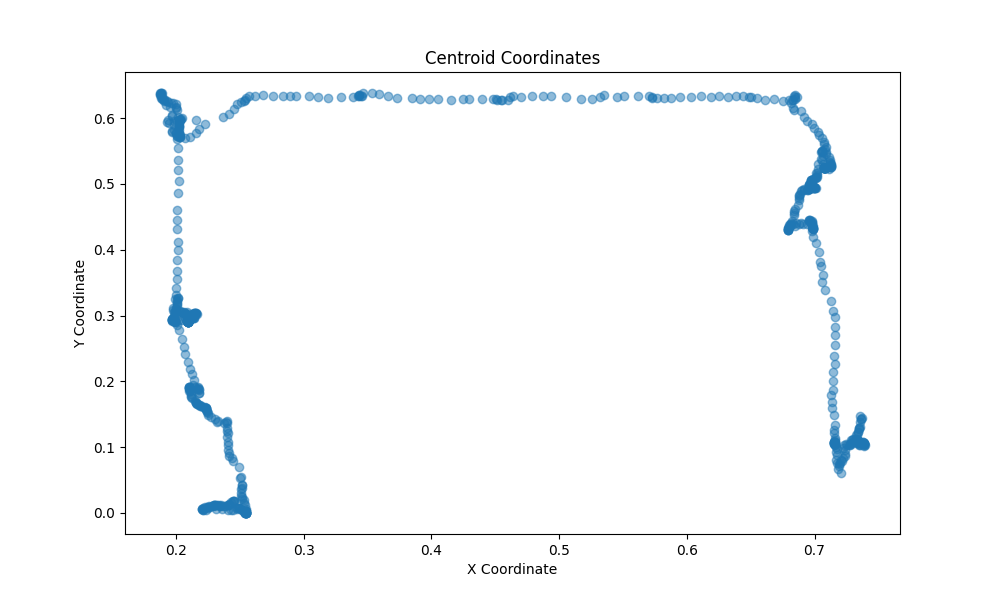

In [4]:
# Initialize lists to store the x and y coordinates of the centroids
x_coords = []
y_coords = []

# Get a list of all txt files in the directory
txt_files = sorted([f for f in os.listdir(txt_dir) if f.endswith('.txt')])

# Loop over each txt file (each file represents one frame)
for txt_file in txt_files:
    # Open the txt file
    with open(os.path.join(txt_dir, txt_file), 'r') as f:
        # Read the lines in the txt file
        lines = f.readlines()
        
        # Loop over each line in the txt file
        for line in lines:
            # Split the line into components
            components = line.strip().split()
            
            # Parse the bounding box coordinates
            x_center = float(components[1])
            y_center = float(components[2])
            
            # Add the centroid coordinates to the lists
            x_coords.append(x_center)
            y_coords.append(y_center)

# Find the maximum y-coordinate
max_y = max(y_coords)

# Subtract each y-coordinate from the maximum to invert the data
y_coords = [max_y - y for y in y_coords]

# Plot the x and y coordinates of the centroids
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_coords, y_coords, alpha=0.5)

# Set the title and labels
ax.set_title('Centroid Coordinates')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Show the plot
plt.show()


# Draw Single or Multiple ROIs for Analysis

### Name your ROIs in an order (e.g., ROI1, ROI2, ROI3,...). Seperate Each ROI name with a comma ' , '

Name the ROIs (ROI1, ROI2, ROI3,...) ROI, ROI2, ROI3, ROI4


<IPython.core.display.Javascript object>


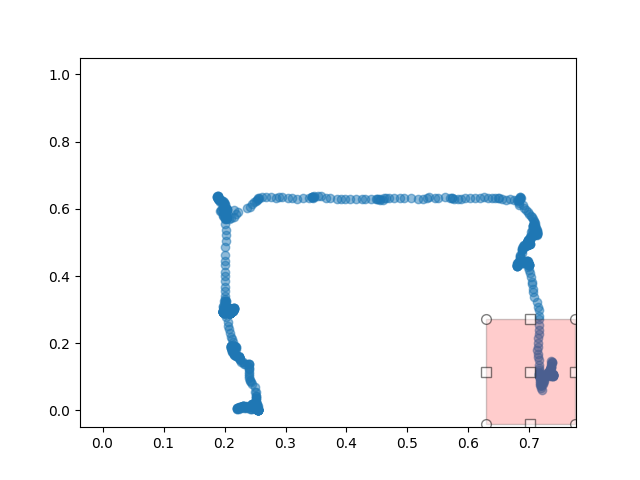

In [7]:
# Ask the user to enter the names of the ROIs
roi_names = input("Name the ROIs (ROI1, ROI2, ROI3,...) ").split(',')

# Initialize a dictionary to store the coordinates of the ROIs
rois = {name: None for name in roi_names}

# Function to be called when the user draws a rectangle
def onselect(eclick, erelease):
    # Get the coordinates of the rectangle
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    # Find the first ROI without coordinates
    for name in roi_names:
        if rois[name] is None:
            # Store the coordinates in the rois dictionary
            rois[name] = ((x1, y1), (x2, y2))
            
            # Print the coordinates of the ROI
            print(f"{name}: ({x1}, {y1}), ({x2}, {y2})")
            break

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot the centroids
ax.scatter(x_coords, y_coords, alpha=0.5)


# Create the rectangle selector
rs = RectangleSelector(ax, onselect, useblit=True,
                       button=[1, 3],  # Use left or right mouse buttons
                       minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)

# Show the plot
plt.show()


# Average Speed & Time Spent in Each ROI

In [8]:
# Initialize counters for time spent in each ROI and lists to store speeds in each ROI
time_in_rois = [0 for _ in range(len(rois))]
speeds_in_rois = [[] for _ in range(len(rois))]

# Initialize variables for speed calculation
prev_x, prev_y, speed = None, None, 0
speeds = []

# Loop over each frame
for x, y in zip(x_coords, y_coords):  # Use original coordinates here
    # Calculate speed
    if prev_x is not None and prev_y is not None:
        dx = x - prev_x
        dy = y - prev_y
        speed = np.sqrt(dx**2 + dy**2) * 30  # Multiply by 30 to convert from frames to seconds. Replace with 60 if video is 60fps
        speeds.append(speed)

    # Check if the centroid is in each ROI
    for i, roi in enumerate(rois):
        ((x1, y1), (x2, y2)) = rois[roi]
        in_roi = x1 <= x <= x2 and y1 <= y <= y2

        if in_roi:
            # If the object is in the ROI, increment the time counter and add the speed to the list
            time_in_rois[i] += 1
            speeds_in_rois[i].append(speed)

    # Update the previous position
    prev_x, prev_y = x, y

# Convert time from frames to seconds and calculate average speeds
time_in_rois = [t / 30 for t in time_in_rois]
avg_speeds_in_rois = [np.mean(s) if s else 0 for s in speeds_in_rois]

print(f"Average Speed: {np.mean(speeds)} units per second")
print(f"Time Spent in Each ROI: {time_in_rois} seconds")
print(f"Average Speed in Each ROI: {avg_speeds_in_rois} units per second")


Average Speed: 2.7058611073887517 units per second
Time Spent in Each ROI: [11.466666666666667, 12.966666666666667, 5.066666666666666, 3.4] seconds
Average Speed in Each ROI: [1.9336911155384906, 3.4010240328168617, 6.569886432323587, 1.5492381324158817] units per second


# Entries & Exits Made Per ROI

### This section of the code smooths the coordinates over user defined window_size (similar to moving average).

In [9]:
# Define the smoothing window size
window_size = 30  # Adjust this value as needed

# Convert the centroid coordinates to a DataFrame
df = pd.DataFrame({'x': x_coords, 'y': y_coords})

# Apply a rolling window and calculate the mean to smooth the coordinates
df['x_smooth'] = df['x'].rolling(window=window_size, min_periods=1).mean()
df['y_smooth'] = df['y'].rolling(window=window_size, min_periods=1).mean()

# Initialize counters for entries and exits for each ROI
entries = [0 for _ in range(len(rois))]
exits = [0 for _ in range(len(rois))]

# Initialize variables for tracking the object's position
prev_x, prev_y = None, None
prev_in_rois = [False for _ in range(len(rois))]

# Loop over each frame
for x, y in zip(df['x_smooth'], df['y_smooth']):
    # Check if the centroid is in each ROI
    for i, roi in enumerate(rois):
        ((x1, y1), (x2, y2)) = rois[roi]
        in_roi = x1 <= x <= x2 and y1 <= y <= y2

        # If we have a previous position
        if prev_x is not None and prev_y is not None:
            # If the object has moved from outside the ROI to inside, increment the entries counter
            if not prev_in_rois[i] and in_roi:
                entries[i] += 1

            # If the object has moved from inside the ROI to outside, increment the exits counter
            if prev_in_rois[i] and not in_roi:
                exits[i] += 1

        # Update the previous position and ROI status
        prev_x, prev_y = x, y
        prev_in_rois[i] = in_roi

print(f"Entries in Each ROI: {entries}")
print(f"Exits from Each ROI: {exits}")



Entries in Each ROI: [1, 2, 2, 1]
Exits from Each ROI: [1, 1, 1, 1]


# Graph Entries/Exits, and First ROI Entered

<IPython.core.display.Javascript object>


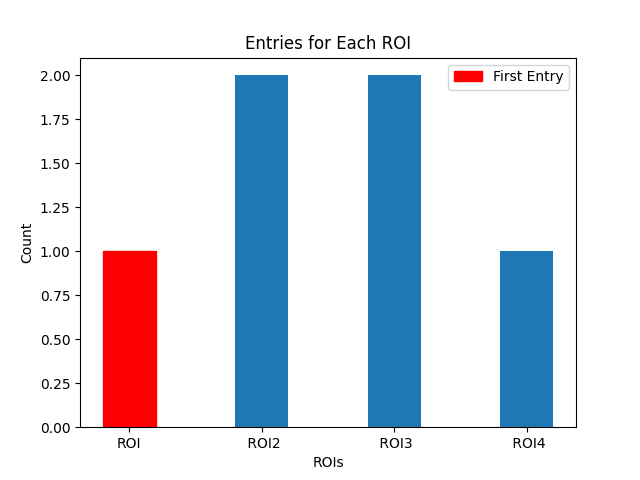

<IPython.core.display.Javascript object>


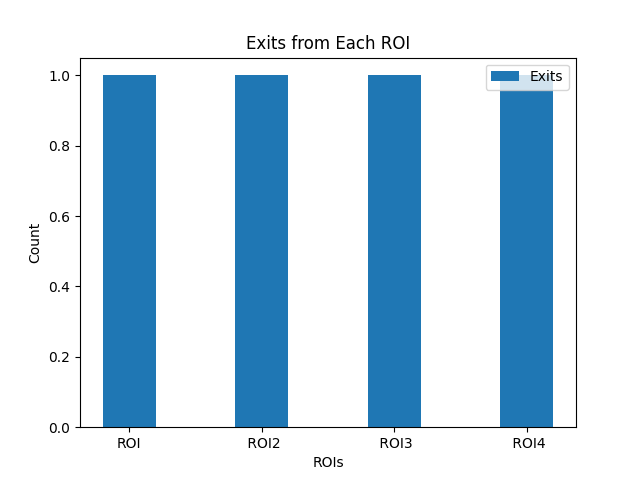

In [10]:
# Assuming entries is a list of entry counts for each ROI
first_entry_roi = roi_names[entries.index(next((e for e in entries if e > 0), 0))]

# Create a new figure for the entries bar graph
fig1, ax1 = plt.subplots()

# Create an array with the positions of each bar along the x-axis
x = np.arange(len(rois))

# Plot a bar for the entries of each ROI
bars = ax1.bar(x, entries, 0.4, label='Entries')

# Change the color of the first entry ROI bar to red
bars[roi_names.index(first_entry_roi)].set_color('red')

# Label the x-axis with the names of the ROIs
ax1.set_xticks(x)
ax1.set_xticklabels(roi_names)

# Add labels and a custom legend
ax1.set_xlabel('ROIs')
ax1.set_ylabel('Count')
ax1.set_title('Entries for Each ROI')
red_patch = mpatches.Patch(color='red', label='First Entry')
ax1.legend(handles=[red_patch])

# Show the plot
plt.show()

# Create a new figure for the exits bar graph
fig2, ax2 = plt.subplots()

# Plot a bar for the exits of each ROI
ax2.bar(x, exits, 0.4, label='Exits')

# Label the x-axis with the names of the ROIs
ax2.set_xticks(x)
ax2.set_xticklabels(roi_names)

# Add labels and a legend
ax2.set_xlabel('ROIs')
ax2.set_ylabel('Count')
ax2.set_title('Exits from Each ROI')
ax2.legend()

# Show the plot
plt.show()
